In [1]:
!git clone https://github.com/BogChamp/exchange_features.git

Cloning into 'exchange_features'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 21 (delta 10), reused 14 (delta 6), pack-reused 0
Receiving objects: 100% (21/21), 46.25 KiB | 1.44 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
! ls -la

total 16
drwxr-xr-x 4 root root 4096 Dec 20 04:48 .
drwxr-xr-x 5 root root 4096 Dec 20 04:47 ..
drwxr-xr-x 2 root root 4096 Dec 20 04:48 .virtual_documents
drwxr-xr-x 3 root root 4096 Dec 20 04:48 exchange_features


In [5]:
!pip3 install gdown -q
# !pip3 install polars -q
# !pip3 install numba -q
# !pip3 install numba-progress -q
# !pip3 install cupy -q

In [3]:
from exchange_features.numba_functions import numba_imb, numba_calculate_past_returns, numba_log_returns, numba_data_autocorrelation, numba_data_realized_kernel
from exchange_features.numpy_functions import numpy_imb, numpy_calculate_past_returns, numpy_log_returns, numpy_data_autocorrelation, numpy_data_realized_kernel
from exchange_features.cupy_functions import cupy_imb, cupy_calculate_past_returns, cupy_log_returns, cupy_data_autocorrelation, cupy_data_realized_kernel
%autoreload 2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
UsageError: Line magic function `%autoreload` not found.


In [7]:
import gdown
import numpy as np
import cupy as cp
import pandas as pd
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import numba as nb
from numba import njit
import time 

%load_ext autoreload

In [8]:
url = "https://drive.google.com/file/d/15E15XFVD8laDXNhw7uPpcPiWw-IGkYfv/view?usp=sharing"
output = 'book2h.parquet'
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1iTOy1bcQlgyuz-V2U-zgCFfzOuRm7NyN/view?usp=sharing"
output = "ticker2h.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1Ro-3FbjQC2FDYIg1UZG7TIFEWOQkQ4uG/view?usp=sharing"
output = "trades2h.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

'trades2h.parquet'

# Improved order book imbalances

In [9]:
book = pl.read_parquet('book2h.parquet')
ticker = pl.read_parquet('ticker2h.parquet')
trades = pl.read_parquet('trades2h.parquet')
trades = trades.with_columns(pl.col('side').cast(pl.Float32, strict=False))

In [11]:
book_numpy = book.to_numpy()
ticker_numpy = ticker.to_numpy()
trades_numpy = trades.to_numpy()

In [12]:
ob_sizes_array = np.array([book_numpy.shape[0] // 10 for _ in range(10)])
ob_sizes_array[np.arange(ob_sizes_array.shape[0]) <= (book_numpy.shape[0] % 10)] += 1
ob_sizes_array = np.cumsum(ob_sizes_array)

In [13]:
numba_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    numba_imbalance = np.array(numba_imb(book_numpy[:size]))
    end = time.perf_counter()
    numba_times.append(end - start)

100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


In [14]:
numpy_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    numpy_imbalance = np.array(numpy_imb(book_numpy[:size]))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [05:14<00:00, 31.44s/it]


In [24]:
cupy_times = []

for size in tqdm(ob_sizes_array):
    start = time.perf_counter()
    cupy_imbalance = np.array(cupy_imb(book_numpy[:size]))
    end = time.perf_counter()
    cupy_times.append(end - start)

100%|██████████| 10/10 [11:01<00:00, 66.13s/it]


Text(0.5, 0, 'array_size')

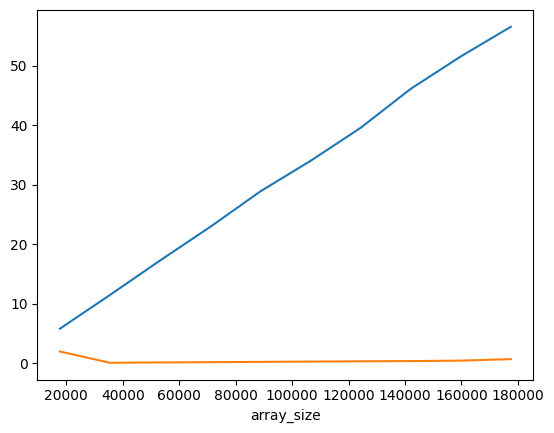

In [19]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Improved order book imbalances')

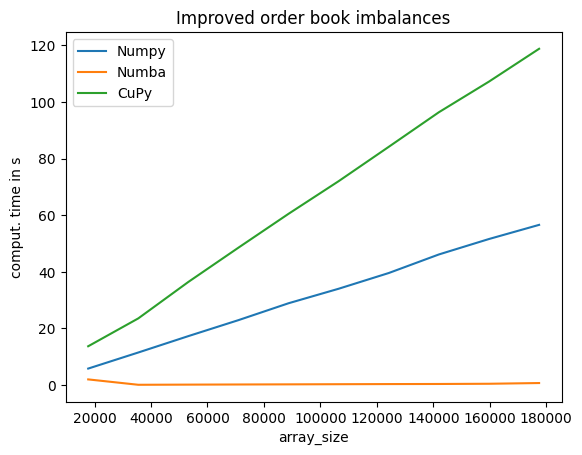

In [25]:
plt.plot(ob_sizes_array, numpy_times, label='Numpy')
plt.plot(ob_sizes_array, numba_times, label='Numba')
plt.plot(ob_sizes_array, cupy_times, label='CuPy')
plt.xlabel('array_size')
plt.legend()
plt.ylabel('comput. time in s')
plt.title('Improved order book imbalances')

# Past Return

In [26]:
trades_sizes_array = np.array([trades_numpy.shape[0] // 10 for _ in range(10)])
trades_sizes_array[np.arange(trades_sizes_array.shape[0]) <= (trades_numpy.shape[0] % 10)] += 1
trades_sizes_array = np.cumsum(trades_sizes_array)


In [27]:
past_returns_window = 50

In [46]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numba_past_return = np.array(numba_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    numba_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 23.75it/s]


In [47]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numpy_past_return = np.array(numpy_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [02:13<00:00, 13.37s/it]


In [45]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    cupy_past_return = np.array(cupy_calculate_past_returns(trades_numpy[:size].astype(float), past_returns_window))
    end = time.perf_counter()
    cupy_times.append(end - start)

100%|██████████| 10/10 [12:19<00:00, 73.98s/it] 


Text(0.5, 1.0, 'Past return, window size = 50')

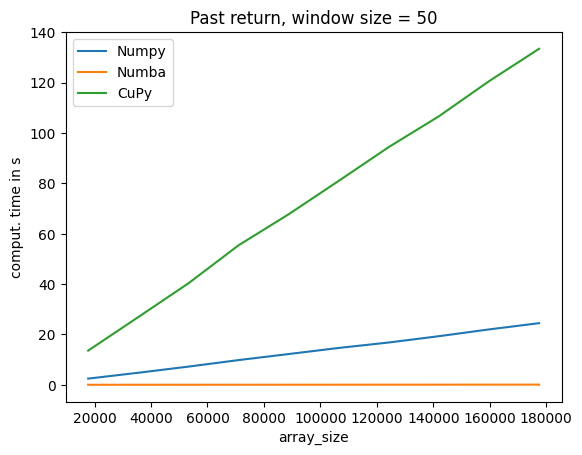

In [48]:
plt.plot(ob_sizes_array, numpy_times, label='Numpy')
plt.plot(ob_sizes_array, numba_times, label='Numba')
plt.plot(ob_sizes_array, cupy_times, label='CuPy')
plt.xlabel('array_size')
plt.legend()
plt.ylabel('comput. time in s')
plt.title('Past return, window size = 50')

# Log returns

In [64]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numba_log_ret = np.array(numba_log_returns(trades_numpy[:size][:, 1].astype(float)))
    end = time.perf_counter()
    numba_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 496.81it/s]


In [66]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    numpy_log_ret = np.array(numpy_log_returns(trades_numpy[:size][:, 1].astype(float)))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 1053.42it/s]


In [53]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    cupy_log_ret = cp.asnumpy(cupy_log_returns(trades_numpy[:size][:, 1].astype(float))) 
    end = time.perf_counter()
    cupy_times.append(end - start)


100%|██████████| 10/10 [00:00<00:00, 18.77it/s]


Text(0.5, 1.0, 'Log return')

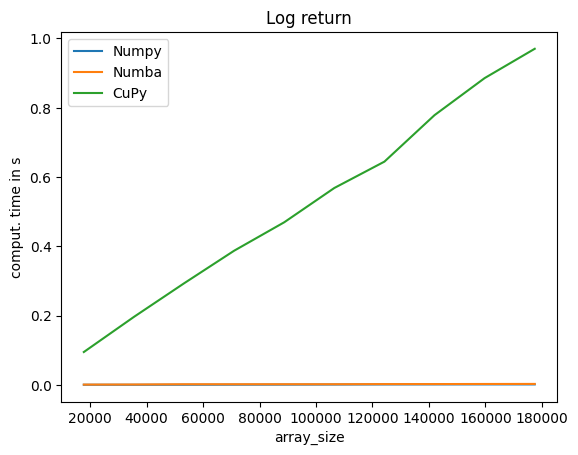

In [67]:
plt.plot(ob_sizes_array, numpy_times, label='Numpy')
plt.plot(ob_sizes_array, numba_times, label='Numba')
plt.plot(ob_sizes_array, cupy_times, label='CuPy')
plt.xlabel('array_size')
plt.legend()
plt.ylabel('comput. time in s')
plt.title('Log return')

# Autocorrelation

In [55]:
autocorrelation_time_window = 10**5 # ms
lags = np.array([1])

In [56]:
log_ret = np.stack([numba_log_ret, trades_numpy[1:, 0]], axis=1)

In [61]:
numba_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numba_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    numba_times.append(end - start)

100%|██████████| 10/10 [00:00<00:00, 41.44it/s]


In [58]:
numpy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numpy_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    numpy_times.append(end - start)

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [59]:
cupy_times = []

for size in tqdm(trades_sizes_array):
    start = time.perf_counter()
    autocorrelations_per_lag = np.array(numpy_data_autocorrelation(log_ret[:size], lags, autocorrelation_time_window))
    end = time.perf_counter()
    cupy_times.append(end - start)

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Text(0.5, 1.0, 'Autocorrelation')

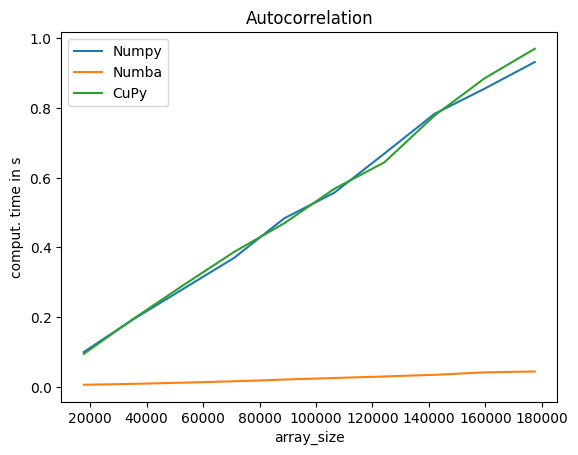

In [62]:
plt.plot(ob_sizes_array, numpy_times, label='Numpy')
plt.plot(ob_sizes_array, numba_times, label='Numba')
plt.plot(ob_sizes_array, cupy_times, label='CuPy')
plt.xlabel('array_size')
plt.legend()
plt.ylabel('comput. time in s')
plt.title('Autocorrelation')